In [1]:
%matplotlib inline
import pandas as pd

In [2]:
ages = pd.read_csv('sheep_age.csv', index_col="id")
print(ages.shape)
ages.head()

(28, 1)


,age
id,
1,8
2,8
3,4
4,7
5,8


In [3]:
wins = pd.read_csv('sheep_edges.csv')
print(wins.shape)
wins.head()

(250, 3)


,source,target,weight
0,1,2,1
1,1,3,1
2,1,4,1
3,1,5,1
4,1,6,1


In [75]:
wins = pd.read_csv('sheep_edges.csv')
print(wins.shape)
wins.sort_values(by="weight", ascending=False).head(20)

(250, 3)


,source,target,weight
28,22,23,12
23,22,3,12
227,24,6,11
249,21,6,10
53,8,3,10
213,18,23,10
78,9,26,9
231,25,20,8
106,3,23,8
37,28,22,8


In [76]:
wins[wins.source==1]

,source,target,weight
0,1,2,1
1,1,3,1
2,1,4,1
3,1,5,1
4,1,6,1


In [93]:
import numpy as np
win_difference = wins[wins.source < wins.target].copy()
for idx, row in win_difference.iterrows():
    src, tgt = row[0:2]
    mask = (wins.source == tgt) & (wins.target == src)
    if np.sum(mask) > 0:
        w = wins[mask].weight.iloc[0]
        win_difference.at[idx, "weight"] -= w
print(win_difference.head())
mask = win_difference.weight < 0
print(win_difference[mask])
win_difference.loc[mask, "weight"] = win_difference.loc[mask, "weight"] * -1
win_difference.loc[mask, "source"], win_difference.loc[mask, "target"] = \
            win_difference.loc[mask].target, win_difference.loc[mask].source 
print(win_difference[mask])

   source  target  weight
0       1       2       1
1       1       3       1
2       1       4       1
3       1       5       1
4       1       6       1
     source  target  weight
91        2      12      -1
100       3       8      -9
103       3       4      -1
153      13      14      -1
214      18      24      -2
215      18      25      -2
246      20      26      -4
     source  target  weight
91       12       2       1
100       8       3       9
103       4       3       1
153      14      13       1
214      24      18       2
215      25      18       2
246      26      20       4


In [172]:
win_difference.weight.describe()

count    168.000000
mean       2.535714
std        2.076077
min        0.000000
25%        1.000000
50%        2.000000
75%        3.000000
max       12.000000
Name: weight, dtype: float64

In [178]:
nwins = wins.loc[:, ("source", "weight")].groupby(by="source").sum().fillna(0)
nwins.head()

,weight
source,
1,5
2,35
3,63
4,25
5,2


In [179]:
nlosses = wins.loc[:, ("target", "weight")].groupby(by="target").sum().fillna(0)
nlosses.head()

,weight
target,
2,9
3,36
4,15
5,5
6,62


In [182]:
ages["nwins"] = nwins.weight
ages["nlosses"] = nlosses.weight
ages.nwins = ages.nwins.fillna(0)
ages.nlosses = ages.nlosses.fillna(0)
ages["nfights"] = ages.nwins + ages.nlosses
ages.sort_values(by="nwins", ascending=False)

,age,nwins,nlosses,nfights
id,,,,
22,1,65.0,10.0,75.0
3,4,63.0,36.0,99.0
8,4,56.0,18.0,74.0
9,7,52.0,18.0,70.0
7,5,43.0,1.0,44.0
18,1,35.0,25.0,60.0
2,8,35.0,9.0,44.0
28,9,32.0,12.0,44.0
14,1,31.0,28.0,59.0


In [8]:
import networkx as nx

In [221]:
G = nx.DiGraph()
ages = ages.sample(frac=1, random_state=42)
for id_ in ages.index.values:
    G.add_node(id_)
wd_mask = win_difference.weight > win_difference.weight.median()
edges = [row.values[:3] for idx, row in win_difference[wd_mask].iterrows()]
print(edges[:5])
G.add_weighted_edges_from(edges)

[array([7, 8, 5], dtype=int64), array([ 7, 13,  4], dtype=int64), array([ 7, 15,  3], dtype=int64), array([ 7, 16,  4], dtype=int64), array([ 7, 19,  7], dtype=int64)]


In [222]:
from matplotlib import cm
from matplotlib import pyplot as plt
import matplotlib

edge_colors = (win_difference[wd_mask].weight
               / (win_difference[wd_mask].weight.max() - win_difference[wd_mask].weight.min()))
node_sizes = ages.nfights.values * 20
node_colors = ages.nwins / (ages.nwins.max() - ages.nwins.min())

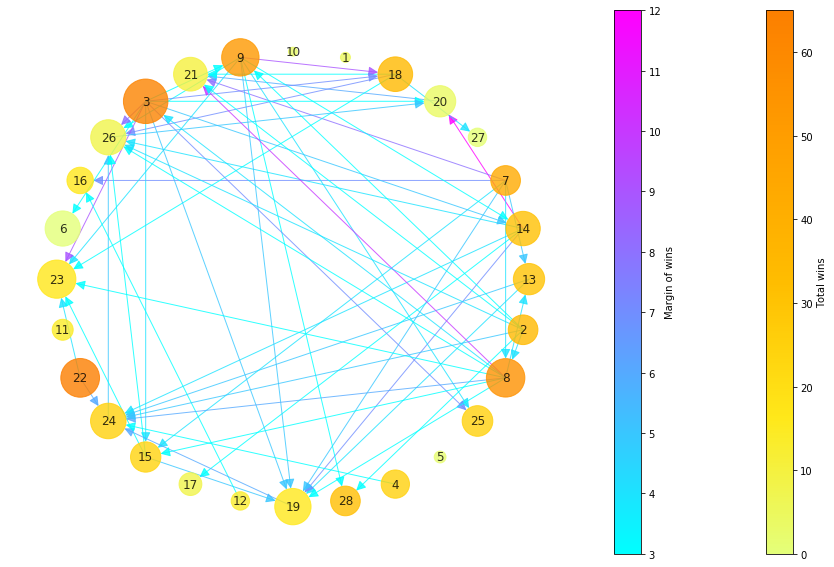

In [227]:
fig, ax = plt.subplots(figsize=(16, 10))
fig.colorbar(cm.ScalarMappable(
    norm=matplotlib.colors.Normalize(
        vmin=ages.nwins.min(),
        vmax=ages.nwins.max(), 
        clip=False),
    cmap=cm.Wistia)).set_label("Total wins")
fig.colorbar(cm.ScalarMappable(
    norm=matplotlib.colors.Normalize(
        vmin=win_difference[wd_mask].weight.min(), 
        vmax=win_difference[wd_mask].weight.max(),
        clip=False),
    cmap=cm.cool)).set_label("Margin of wins")
nx.draw_circular(G,
                 ax=ax,
                 node_color=node_colors,
                 cmap=cm.Wistia,
                 node_size=node_sizes,
                 arrowsize=20,
                 font_size=12,
                 edge_color=edge_colors,
                 edge_cmap=cm.cool,
                 alpha=0.8,
                 with_labels=True)

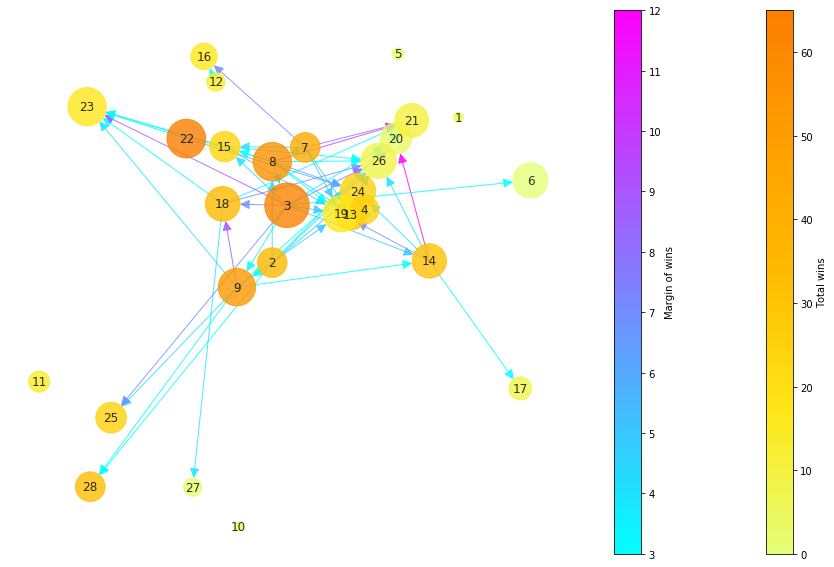

In [226]:
import matplotlib
fig, ax = plt.subplots(figsize=(16, 10))
fig.colorbar(cm.ScalarMappable(
    norm=matplotlib.colors.Normalize(
        vmin=ages.nwins.min(),
        vmax=ages.nwins.max(), 
        clip=False),
    cmap=cm.Wistia)).set_label("Total wins")
fig.colorbar(cm.ScalarMappable(
    norm=matplotlib.colors.Normalize(
        vmin=win_difference[wd_mask].weight.min(), 
        vmax=win_difference[wd_mask].weight.max(),
        clip=False),
    cmap=cm.cool)).set_label("Margin of wins")
nx.draw_spring(G,
                 ax=ax,
                 node_color=node_colors,
                 cmap=cm.Wistia,
                 node_size=node_sizes,
                 arrowsize=20,
                 font_size=12,
                 edge_color=edge_colors,
                 edge_cmap=cm.cool,
                 alpha=0.8,
                 with_labels=True)

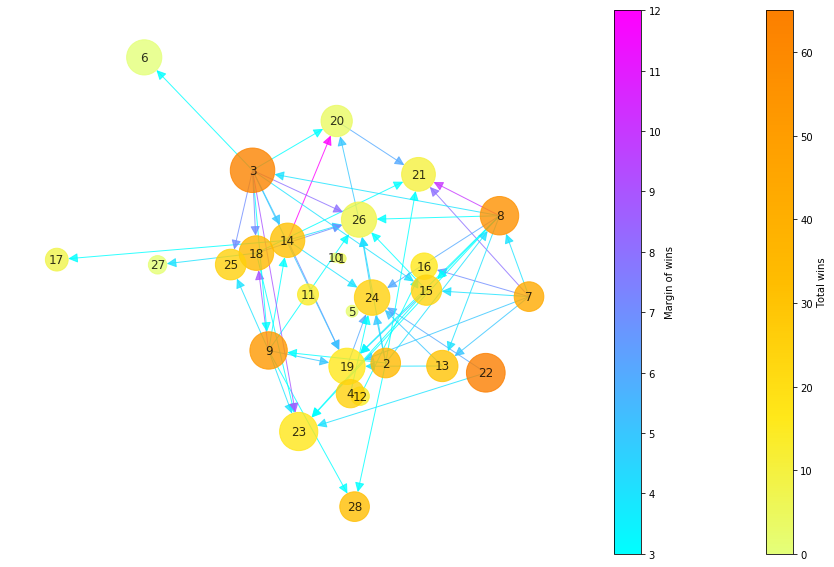

In [228]:
import matplotlib
fig, ax = plt.subplots(figsize=(16, 10))
fig.colorbar(cm.ScalarMappable(
    norm=matplotlib.colors.Normalize(
        vmin=ages.nwins.min(),
        vmax=ages.nwins.max(), 
        clip=False),
    cmap=cm.Wistia)).set_label("Total wins")
fig.colorbar(cm.ScalarMappable(
    norm=matplotlib.colors.Normalize(
        vmin=win_difference[wd_mask].weight.min(), 
        vmax=win_difference[wd_mask].weight.max(),
        clip=False),
    cmap=cm.cool)).set_label("Margin of wins")
nx.draw_kamada_kawai(G,
                 ax=ax,
                 node_color=node_colors,
                 cmap=cm.Wistia,
                 node_size=node_sizes,
                 arrowsize=20,
                 font_size=12,
                 edge_color=edge_colors,
                 edge_cmap=cm.cool,
                 alpha=0.8,
                 with_labels=True)